
# Early-Warning System for Workplace Safety — ML Proof of Concept


**Pipeline**
1. Load & combine filtered CSVs.
2. Clean Data and Calculate Incident Rate
3. Build features and Train/Test Model.
4. Plotting predictions vs actual
5. Feature Importance.
6. Nutrien like Scenario



## 1) Load CSV files and combine them



In [1]:
import re
from pathlib import Path
import pandas as pd

DATA_DIR = Path('.')
files = sorted((DATA_DIR).glob('filtered*.csv'))

print(f"Found {len(files)} files")

frames = []
for p in files:
    try:
        df = pd.read_csv(p, encoding='utf-8', low_memory=False) # Try different encodings
    except UnicodeDecodeError:
        df = pd.read_csv(p, encoding='latin1', low_memory=False)
    m = re.search(r'(\d{4})', p.stem)
    df['__source_file'] = p.name
    frames.append(df)


raw = pd.concat(frames, ignore_index=True)

print(str(raw.shape[0]) + " rows in total")
print(str(raw.shape[1]) + " columns in total")

Found 9 files
7049 rows in total
57 columns in total



## 2) Cleaning up the Data and Finding Incident Rates

In [6]:
# iompute Total Recordable Cases (TRC) (sum of the three recordable case categories)
raw["trc"] = raw["total_dafw_cases"].fillna(0) + raw["total_djtr_cases"].fillna(0) + raw["total_other_cases"].fillna(0)

# incident Rate = (TRC * 200,000) / Total Hours Worked
raw["incident_rate"] = (raw["trc"] * 200_000.0) / raw["total_hours_worked"]

# keeping only columns that matter
keep_cols = [
    "naics_code",
    "annual_average_employees", "total_hours_worked",
    "trc", "incident_rate"
]
keep_cols = [c for c in keep_cols if c in raw.columns]
model_df = raw[keep_cols].copy()

# convert to string to make scikit happy
model_df["naics_code"] = (
    pd.to_numeric(model_df["naics_code"], errors="coerce")
      .astype("Int64")
      .astype(str)
)

# threshold for classification taken as median incident rate since mean can easily be skewed by outliers
threshold = model_df["incident_rate"].median()
print(f"Median incident rate threshold: {threshold:.2f}\n")

# assigning risk labels based on the threshold -> 1 if high risk and 0 if low risk
model_df["risk_label"] = (model_df["incident_rate"] > threshold).astype(int)

# rename for better semantics
model_df = model_df.rename(columns={
    "annual_average_employees": "reported_avg_employees",
    "total_hours_worked": "reported_total_hours"
})

# Final cleaned dataset to feed into the model (model_df)
print("Modeling dataset shape:", model_df.shape)
model_df.head(5)


Median incident rate threshold: 0.77

Modeling dataset shape: (7049, 6)


,naics_code,reported_avg_employees,reported_total_hours,trc,incident_rate,risk_label
0,325199,47.0,99202.0,1.0,2.016088,1
1,325180,44.0,86555.0,1.0,2.310670,1
2,325180,40.0,78360.0,0.0,0.000000,0
3,325180,24.0,50860.0,0.0,0.000000,0
4,325314,28.0,78646.0,0.0,0.000000,0



## 3) Build features and Training/Testing Model

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd

# Features and target
features = ["naics_code", "annual_average_employees", "total_hours_worked"]

target = "risk_label"

# Prepare the dataset
X = model_df[features].copy()
y = model_df[target].astype(int).values

# Splitting features
cat_feats = ["naics_code"]
num_feats = ["annual_average_employees", "total_hours_worked"]

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats),
    ("num", "passthrough", num_feats)
])

# Model & pipeline for training and testing
clf = GradientBoostingClassifier(random_state=67)
pipe = Pipeline([("prep", pre), ("model", clf)])

# 80/20 Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=67
)

# Training
pipe.fit(X_train, y_train)

# Predicting probabilities using a 0.4 Threshold
# Giving up Accuracy for better Recall (Less False Negatives)
THRESHOLD = 0.40
proba = pipe.predict_proba(X_test)[:, 1]
pred  = (proba >= THRESHOLD).astype(int)

# Metrics
acc = accuracy_score(y_test, pred)
prec = precision_score(y_test, pred, zero_division=0)
rec  = recall_score(y_test, pred)
f1   = f1_score(y_test, pred)

print(f"\nThreshold used: {THRESHOLD}")
print(f"Accuracy: {acc:.3f}")
print(f"Precision (class 1): {prec:.3f}") # Rate of catching false positives
print(f"Recall (class 1): {rec:.3f}") # Rate of catching false negatives
print(f"F1 (class 1): {f1:.3f}\n")  # Balance between precision and recall

print("Classification Report:")
print(classification_report(y_test, pred, digits=3))
print("Confusion Matrix:")


Threshold used: 0.4
Accuracy: 0.618
Precision (class 1): 0.590
Recall (class 1): 0.878
F1 (class 1): 0.706

Classification Report:
              precision    recall  f1-score   support

           0      0.713     0.333     0.454       673
           1      0.590     0.878     0.706       737

    accuracy                          0.618      1410
   macro avg      0.652     0.605     0.580      1410
weighted avg      0.649     0.618     0.586      1410

Confusion Matrix:



## 4) Predicted vs Actual (test set)


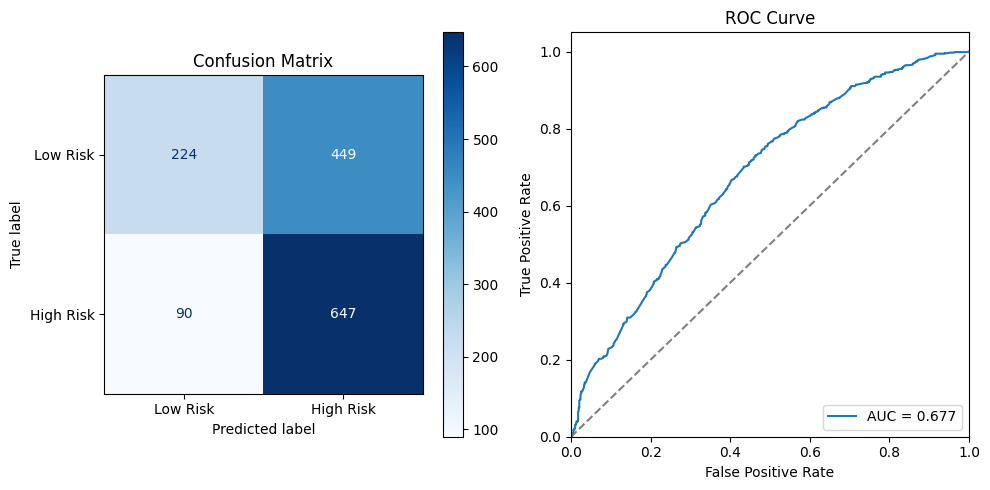

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Risk", "High Risk"])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Confusion Matrix Heatmap
disp.plot(ax=axes[0], cmap="Blues", values_format="d")
axes[0].set_title("Confusion Matrix")

# --- ROC Curve ---
# Get predicted probabilities for positive class (High Risk)
proba = pipe.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, proba)
auc = roc_auc_score(y_test, proba)

axes[1].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()



## 5) Feature importance


,group,importance
0,total_hours_worked,0.616107
1,annual_average_employees,0.235152
2,naics_code (all),0.148741


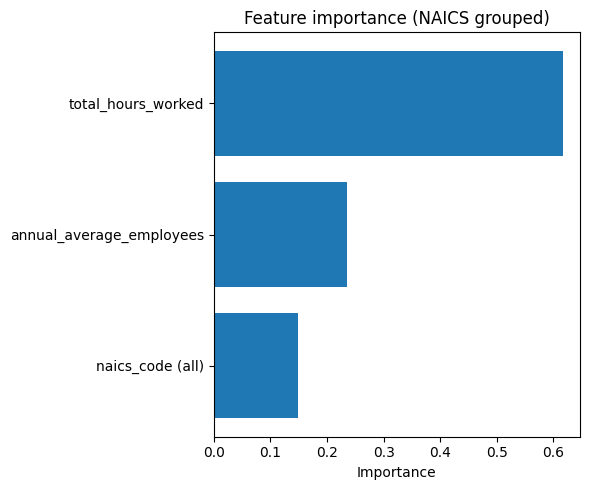

In [44]:
import matplotlib.pyplot as plt

# Build feature-name list from the fitted pipeline 
naics_col = "naics_code"
cat_names = []
if naics_col in X.columns:
    ohe = pipe.named_steps["prep"].named_transformers_["cat"]
    cat_names = list(ohe.get_feature_names_out([naics_col]))
num_names = num_feats  # from earlier split
all_names = cat_names + num_names


# Raw importances from the fitted model
importances = pipe.named_steps["model"].feature_importances_
imp_df = pd.DataFrame({"feature": all_names, "importance": importances})


# Collapse all NAICS one-hots into a single group
def to_group_name(f):
    # handle one-hots like 'naics_code_325311'
    if naics_col and f.startswith(f"{naics_col}_"):
        return "naics_code (all)"
    # (if for some reason NAICS passed through without OHE)
    if f == naics_col:
        return "naics_code (all)"
    return f

grouped = (
    imp_df.assign(group=imp_df["feature"].map(to_group_name))
          .groupby("group", as_index=False)["importance"]
          .sum()
          .sort_values("importance", ascending=False)
          .reset_index(drop=True)
)


# Show the grouped table
display(grouped)


# Visualization
top_k = 15
topg = grouped.head(top_k)
plt.figure(figsize=(6, 5))
plt.barh(topg["group"][::-1], topg["importance"][::-1])
plt.xlabel("Importance")
plt.title("Feature importance (NAICS grouped)")
plt.tight_layout()
plt.show()




## 6) Hypothetical Example for a Potash Mining Site



In [ ]:
# NAICS Values for Potash Mining 
potash_naics = "212391"  

# Creating the required baseline facility data for Potash Mining
baseline = pd.DataFrame([{
    "naics_code": potash_naics,
    "annual_average_employees": 900,
    "total_hours_worked": 900 * 2080,  # approx. FTE * hours/year

    **{col: X[col].median() for col in X.columns if col not in ["naics_code", "annual_average_employees", "total_hours_worked"]}
}])

print("Baseline Facility")
display(baseline)

# Predict baseline risk 
baseline_proba = pipe.predict_proba(baseline)[:, 1][0]
print(f"\nBaseline High-Risk Probability: {baseline_proba:.2%}")

# What-if Scenarios
scenarios = pd.DataFrame()

# Scenario 1: +55% employees
scenario1 = baseline.copy()
scenario1["annual_average_employees"] *= 1.15
scenario1_proba = pipe.predict_proba(scenario1)[:, 1][0]

# Scenario 2: +20% hours worked
scenario2 = baseline.copy()
scenario2["total_hours_worked"] *= 1.20
scenario2_proba = pipe.predict_proba(scenario2)[:, 1][0]


# Collect results
scenarios["Scenario"] = ["Baseline", "+15% Employees", "+20% Hours Worked"]
scenarios["High-Risk Probability"] = [
    baseline_proba, scenario1_proba, scenario2_proba]

print("\n=== Scenario Simulation Results ===")
display(scenarios)


Baseline Facility


,naics_code,annual_average_employees,total_hours_worked
0,212391,900,1872000



Baseline High-Risk Probability: 17.38%

=== Scenario Simulation Results ===


,Scenario,High-Risk Probability
0,Baseline,0.173751
1,+15% Employees,0.400017
2,+20% Hours Worked,0.104860



## Data Sources

OSHA Historical Data: https://www.osha.gov/Establishment-Specific-Injury-and-Illness-Data?

Nutrien Rocanville Potash: https://www.cim.org/past-award-winners/nutrien-rocanville-mine/

All defintions and formulas follow OSHA standards

